เริ่มตั้งแต่อัปโหลดไฟล์ CSV
สร้างฉลาก RFT
เตรียมซีเควนซ์
เทรน
ประเมิน
ทดสอบใช้

Step 0) อัปโหลดไฟล์ CSV

ถ้าใช้ Google Colab

In [ ]:
from google.colab import files
uploaded = files.upload()  # เลือกไฟล์ wine_fermentation_dataset-1H.csv


Saving wine_fermentation_dataset-1H_T25-28.csv to wine_fermentation_dataset-1H_T25-28.csv


In [ ]:
import pandas as pd

# อัปโหลดไฟล์ CSV
df = pd.read_csv("wine_fermentation_dataset-1H_T25-28.csv")

# ดูตัวอย่างข้อมูล
df.head()


,Fruit,Batch,Time (Hour),Temperature (°C),pH,Sugar (°Brix),Alcohol (% v/v)
0,Wild Grape,1,0,26.43,3.60,17.95,0.07
1,Wild Grape,1,1,25.76,3.67,18.02,0.32
2,Wild Grape,1,2,26.14,3.57,17.76,0.60
3,Wild Grape,1,3,26.47,3.62,17.80,0.82
4,Wild Grape,1,4,25.24,3.57,17.72,1.24


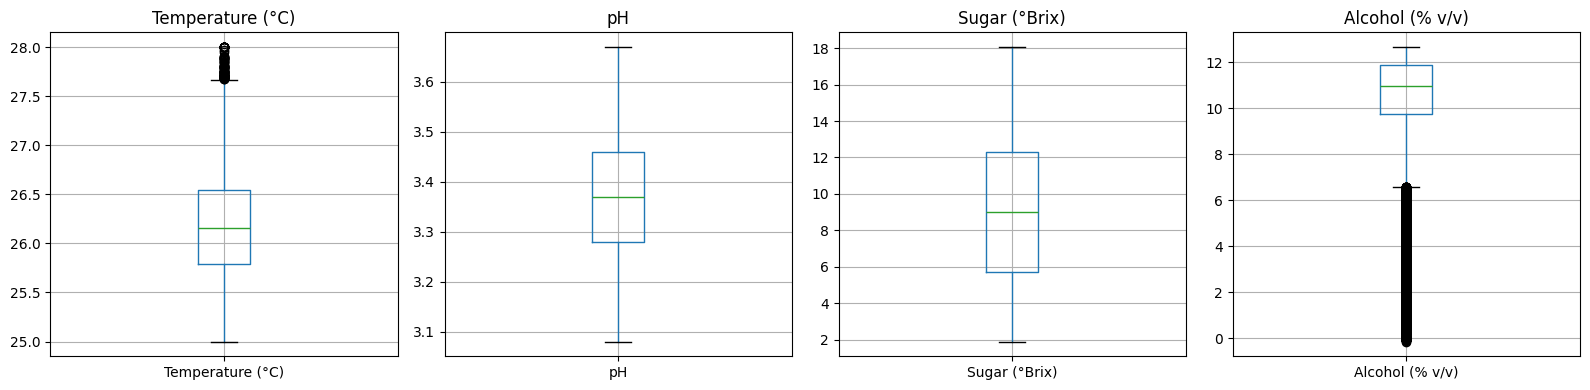

In [ ]:
import matplotlib.pyplot as plt

cols = ["Temperature (°C)", "pH", "Sugar (°Brix)", "Alcohol (% v/v)"]

fig, axes = plt.subplots(1, len(cols), figsize=(16, 4))  # 1 row, 4 columns

for i, col in enumerate(cols):
    df.boxplot(column=col, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

In [ ]:
# หาค่า Q1 (25th percentile) และ Q3 (75th percentile)
Q1 = df["Temperature (°C)"].quantile(0.25)
Q3 = df["Temperature (°C)"].quantile(0.75)

# คำนวณค่า IQR (Interquartile Range)
IQR = Q3 - Q1

# กำหนดขอบเขตสำหรับ outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# ระบุ outliers
outliers = df[(df["Temperature (°C)"] < lower_bound) | (df["Temperature (°C)"] > upper_bound)]

# คำนวณค่ามัธยฐานของคอลัมน์ Temperature (°C)
median_temp = df["Temperature (°C)"].median()

# แทนที่ outliers ด้วยค่ามัธยฐาน
df.loc[outliers.index, "Temperature (°C)"] = median_temp

print(f"พบ outliers {len(outliers)} จุดในคอลัมน์ 'Temperature (°C)' และได้แทนที่ด้วยค่ามัธยฐาน ({median_temp:.2f}) เรียบร้อยแล้ว")

พบ outliers 0 จุดในคอลัมน์ 'Temperature (°C)' และได้แทนที่ด้วยค่ามัธยฐาน (26.16) เรียบร้อยแล้ว


In [ ]:
# หาค่า Q1 (25th percentile) และ Q3 (75th percentile) สำหรับ Alcohol (% v/v)
Q1_alcohol = df["Alcohol (% v/v)"].quantile(0.25)
Q3_alcohol = df["Alcohol (% v/v)"].quantile(0.75)

# คำนวณค่า IQR
IQR_alcohol = Q3_alcohol - Q1_alcohol

# กำหนดขอบเขตสำหรับ outliers
lower_bound_alcohol = Q1_alcohol - 1.5 * IQR_alcohol
upper_bound_alcohol = Q3_alcohol + 1.5 * IQR_alcohol

# ระบุ outliers
outliers_alcohol = df[(df["Alcohol (% v/v)"] < lower_bound_alcohol) | (df["Alcohol (% v/v)"] > upper_bound_alcohol)]

# คำนวณค่ามัธยฐานของคอลัมน์ Alcohol (% v/v)
median_alcohol = df["Alcohol (% v/v)"].median()

# แทนที่ outliers ด้วยค่ามัธยฐาน
df.loc[outliers_alcohol.index, "Alcohol (% v/v)"] = median_alcohol

print(f"พบ outliers {len(outliers_alcohol)} จุดในคอลัมน์ 'Alcohol (% v/v)' และได้แทนที่ด้วยค่ามัธยฐาน ({median_alcohol:.2f}) เรียบร้อยแล้ว")

พบ outliers 0 จุดในคอลัมน์ 'Alcohol (% v/v)' และได้แทนที่ด้วยค่ามัธยฐาน (10.97) เรียบร้อยแล้ว


Step 1: สร้าง RFT (Remaining Fermentation Time)

In [ ]:
# สมมติ dataset มีคอลัมน์ Fruit, Batch, Time (Hour)
df['RFT'] = df.groupby(['Fruit','Batch'])['Time (Hour)'].transform(lambda x: x.max() - x)
display(df['RFT'].head())

,RFT
0,240
1,239
2,238
3,237
4,236


Step 2: กำหนด Features และ Target

In [ ]:
FEATURES = ["Temperature (°C)", "pH", "Sugar (°Brix)", "Alcohol (% v/v)"]
TARGET = 'RFT'
WINDOW = 24  # ใช้ข้อมูลย้อนหลัง 24 ชั่วโมง


Step 3: สร้าง Sequences สำหรับ Time Series

In [ ]:
import numpy as np

def make_sequences(df_part, features=FEATURES, target=TARGET, window=WINDOW):
    X, y = [], []
    for (fruit, batch), g in df_part.groupby(['Fruit','Batch']):
        g = g.sort_values('Time (Hour)').reset_index(drop=True)
        feats = g[features].values
        tgt = g[target].values
        for i in range(window, len(g)):
            X.append(feats[i-window:i])  # ข้อมูลย้อนหลัง window ชั่วโมง
            y.append(tgt[i])
    return np.array(X), np.array(y)

X, y = make_sequences(df)
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (19875, 24, 4)
y shape: (19875,)


Step 4: Split Train/Test และ Scale Features

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Flatten X เพื่อ scale
nsamples, ntimesteps, nfeatures = X.shape
X_flat = X.reshape((nsamples, ntimesteps*nfeatures))

scaler = StandardScaler()
X_flat_scaled = scaler.fit_transform(X_flat)

# แบ่ง train/test
X_train_flat, X_test_flat, y_train, y_test = train_test_split(X_flat_scaled, y, test_size=0.2, random_state=42)

# reshape กลับเป็น 3D สำหรับ ANN หรือ RNN
X_train = X_train_flat.reshape((X_train_flat.shape[0], ntimesteps, nfeatures))
X_test = X_test_flat.reshape((X_test_flat.shape[0], ntimesteps, nfeatures))


Step 5: สร้าง ANN Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential([
    Flatten(input_shape=(WINDOW, len(FEATURES))),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # output = RFT
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,321 (32.50 KB)

 Trainable params: 8,321 (32.50 KB)

 Non-trainable params: 0 (0.00 B)

Step 6: Train Model

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32)


Epoch 1/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 11930.4785 - mae: 82.2506 - val_loss: 379.2646 - val_mae: 14.6325
Epoch 2/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 280.2499 - mae: 12.4362 - val_loss: 115.6107 - val_mae: 7.8102
Epoch 3/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 100.3085 - mae: 7.2844 - val_loss: 67.1441 - val_mae: 5.9566
Epoch 4/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 62.5106 - mae: 5.7443 - val_loss: 50.0606 - val_mae: 5.1827
Epoch 5/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 47.4189 - mae: 5.0896 - val_loss: 44.0544 - val_mae: 4.8585
Epoch 6/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 41.1161 - mae: 4.7322 - val_loss: 37.5875 - val_mae: 4.4830
Epoch 7/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 36.7777 - mae: 4.4477 - val_loss: 34.4194 - val_mae: 4.2877
Epoch 8/50
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 33.4802 - mae: 4.2520 - val_loss: 32.0122 - val_mae: 4.1452
Epoch 9/50
398/398 ━━━━━━━━━━━

Step 7: Evaluate Model

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {mae:.2f} hours")
print(f"Test Loss: {loss:.2f}")


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0487 - mae: 1.2748
Test MAE: 1.27 hours
Test Loss: 2.94


Step 8: Predict Remaining Time จาก Batch ใดๆ

In [ ]:
print(df["Batch"].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25]


In [ ]:
def predict_rft(recent_df, model, scaler, features=FEATURES, window=WINDOW):
    arr = recent_df[features].values[-window:]
    arr_scaled = scaler.transform(arr.reshape(1,-1)).reshape(1, window, len(features))
    pred = model.predict(arr_scaled)
    return float(pred[0][0])

# ตัวอย่าง
example_batch = df[(df['Fruit']=='Java Plum') & (df['Batch']==22)].sort_values('Time (Hour)')
rft_pred_hours = predict_rft(example_batch, model, scaler)
rft_pred_days = rft_pred_hours / 24
print(f"คาดว่าเหลืออีก ~{rft_pred_hours:.1f} ชั่วโมง หรือ ~{rft_pred_days:.1f} วัน")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
คาดว่าเหลืออีก ~-2.1 ชั่วโมง หรือ ~-0.1 วัน


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 

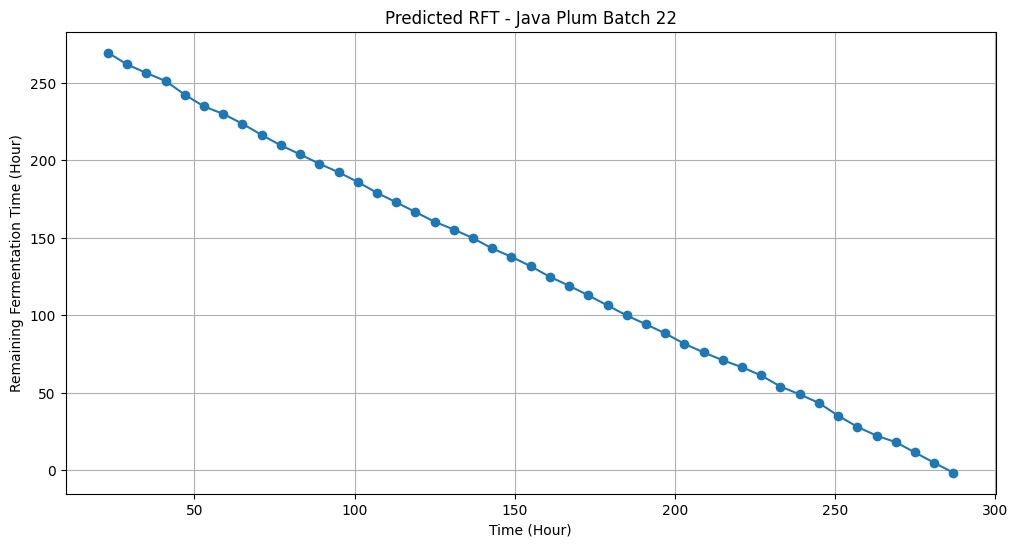

In [ ]:
import matplotlib.pyplot as plt

times, rft_preds = [], []
for i in range(WINDOW, len(example_batch)+1, 6):
    recent = example_batch.iloc[i-WINDOW:i]
    rft_pred = predict_rft(recent, model, scaler)
    times.append(example_batch['Time (Hour)'].iloc[i-1])
    rft_preds.append(rft_pred)

plt.figure(figsize=(12,6))
plt.plot(times, rft_preds, marker='o')
plt.xlabel("Time (Hour)")
plt.ylabel("Remaining Fermentation Time (Hour)")
plt.title("Predicted RFT - Java Plum Batch 22")
plt.grid(True)
plt.show()


In [ ]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)

Saving unseen_wild_grape-1H_0_5D_T24_10Batch.csv to unseen_wild_grape-1H_0_5D_T24_10Batch (1).csv
Uploaded file: unseen_wild_grape-1H_0_5D_T24_10Batch (1).csv


In [ ]:
import pandas as pd

df_unseen = pd.read_csv(filename)
df_unseen.head()


,Fruit,Batch,Time (Hour),Temperature (°C),pH,Sugar (°Brix),Alcohol (% v/v)
0,Wild Grape,1,0,24.56,3.58,18.07,0.01
1,Wild Grape,1,1,24.44,3.60,17.95,0.24
2,Wild Grape,1,2,24.12,3.61,17.86,0.58
3,Wild Grape,1,3,24.28,3.59,17.84,0.87
4,Wild Grape,1,4,23.42,3.61,17.76,1.20


In [ ]:
# เพิ่มคอลัมน์ RFT ให้กับ df_unseen โดยอ้างอิงจากเวลาหมักทั้งหมด 240 ชั่วโมง
# สมมติว่าเวลาหมักทั้งหมดคือ 240 ชั่วโมง
TOTAL_FERMENTATION_TIME = 240
df_unseen['RFT'] = TOTAL_FERMENTATION_TIME - df_unseen['Time (Hour)']

# ดูข้อมูล df_unseen พร้อมคอลัมน์ RFT ใหม่
display(df_unseen.head())

,Fruit,Batch,Time (Hour),Temperature (°C),pH,Sugar (°Brix),Alcohol (% v/v),RFT
0,Wild Grape,1,0,24.56,3.58,18.07,0.01,240
1,Wild Grape,1,1,24.44,3.60,17.95,0.24,239
2,Wild Grape,1,2,24.12,3.61,17.86,0.58,238
3,Wild Grape,1,3,24.28,3.59,17.84,0.87,237
4,Wild Grape,1,4,23.42,3.61,17.76,1.20,236


In [ ]:
# เลือกเฉพาะ batch 9
df_batch9 = df_unseen[df_unseen['Batch'] == 9]

# แสดงตัวอย่าง
print(df_batch9.head(10))  # ดู 10 แถวแรก

           Fruit  Batch  Time (Hour)  Temperature (°C)    pH  Sugar (°Brix)  \
1616  Wild Grape      9            0             24.59  3.58          17.99   
1617  Wild Grape      9            1             23.03  3.59          17.92   
1618  Wild Grape      9            2             24.12  3.62          17.89   
1619  Wild Grape      9            3             23.71  3.62          17.84   
1620  Wild Grape      9            4             24.51  3.66          17.71   
1621  Wild Grape      9            5             24.35  3.62          17.67   
1622  Wild Grape      9            6             24.69  3.62          17.55   
1623  Wild Grape      9            7             23.50  3.58          17.44   
1624  Wild Grape      9            8             24.23  3.58          17.52   
1625  Wild Grape      9            9             24.90  3.61          17.41   

      Alcohol (% v/v)  RFT  
1616            -0.03  240  
1617             0.35  239  
1618             0.57  238  
1619          

In [ ]:
# 5️⃣ Evaluate model on unseen data (หลาย batch)

import numpy as np
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model  # ถ้าโหลดโมเดลจากไฟล์

# --- ฟังก์ชันสร้าง sequence สำหรับหลาย batch ---
def make_unseen_sequences_with_rft_multi_batch(df, window=WINDOW, features=FEATURES, target=TARGET):
    X, y = [], []
    for batch_id, df_batch in df.groupby('Batch'):
        data = df_batch[features].values
        targets = df_batch[target].values
        for i in range(len(data) - window + 1):
            X.append(data[i:i+window])
            y.append(targets[i+window-1])  # RFT ของ timestep สุดท้ายใน sequence
    return np.array(X), np.array(y)

# --- สร้าง sequence และ target ---
X_unseen, y_unseen = make_unseen_sequences_with_rft_multi_batch(df_unseen, window=WINDOW, features=FEATURES, target=TARGET)
print("X_unseen.shape =", X_unseen.shape)
print("y_unseen.shape =", y_unseen.shape)

# --- Flatten sequence ก่อน scale ---
X_unseen_flat = X_unseen.reshape(X_unseen.shape[0], -1)  # shape = (num_seq, window * num_features)

# --- scale ด้วย scaler ที่ fit จาก training data ---
X_unseen_scaled_flat = scaler.transform(X_unseen_flat)

# --- reshape กลับเป็น 3D สำหรับโมเดล ANN หรือ RNN ---
X_unseen_scaled = X_unseen_scaled_flat.reshape((X_unseen_scaled_flat.shape[0], WINDOW, len(FEATURES)))

# --- predict ด้วยโมเดล ---
y_pred_unseen = model.predict(X_unseen_scaled)

# --- คำนวณ MAE ---
mae_unseen = mean_absolute_error(y_unseen, y_pred_unseen)
print(f"\nMean Absolute Error (MAE) on unseen data: {mae_unseen:.2f} hours")




X_unseen.shape = (1820, 24, 4)
y_unseen.shape = (1820,)
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  

Mean Absolute Error (MAE) on unseen data: 125.83 hours


In [ ]:
# ฟังก์ชันทำนาย RFT จากข้อมูลล่าสุดของ batch
def predict_rft_latest(df, model, scaler, window=WINDOW, features=FEATURES):
    """
    df: ข้อมูล unseen ทั้งหมด (มีคอลัมน์ 'Batch')
    model: โมเดล ANN/RNN ที่ฝึกแล้ว
    scaler: StandardScaler ที่ fit จาก training data
    window: ขนาด sequence สำหรับทำนาย
    features: รายชื่อ feature columns
    """
    batches = df['Batch'].unique()
    results = []

    for batch_id in batches:
        df_batch = df[df['Batch'] == batch_id].tail(window)
        if len(df_batch) < window:
            print(f"Batch {batch_id}: ข้อมูลล่าสุดมีเพียง {len(df_batch)} ชั่วโมง ไม่เพียงพอสำหรับ window ขนาด {window}")
            continue

        # เตรียมข้อมูลสำหรับ prediction
        X_input = df_batch[features].values.reshape(1, window, len(features))  # 3D สำหรับ RNN
        X_input_flat = X_input.reshape(1, -1)  # Flatten เพื่อ scale
        X_input_scaled = scaler.transform(X_input_flat).reshape(1, window, len(features))

        # Predict RFT
        rft_pred_hours = model.predict(X_input_scaled)[0][0]
        rft_pred_days = rft_pred_hours / 24
        results.append((batch_id, rft_pred_hours, rft_pred_days))

    return results

# ใช้ฟังก์ชัน
rft_predictions = predict_rft_latest(df_unseen, model, scaler)

# แสดงผล
for batch_id, hours, days in rft_predictions:
    print(f"Batch {batch_id}: เหลือเวลา ~{hours:.1f} ชั่วโมง หรือ ~{days:.1f} วัน")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Batch 1: เหลือเวลา ~228.9 ชั่วโมง หรือ ~9.5 วัน
Batch 2: เหลือเวลา ~96.8 ชั่วโมง หรือ ~4.0 วัน
Batch 3: เหลือเวลา ~168.9 ชั่วโมง หรือ ~7.0 วัน
Batch 4: เหลือเวลา ~90.1 ชั่วโมง หรือ ~3.8 วัน
Batch 5: เหลือเวลา ~214.7 ชั่วโมง หรือ ~8.9 วัน
Batch 6: เหลือเวลา ~87.8 ชั่วโมง หรือ ~3.7 วัน
Batch 7: เหลือเวลา ~91.6 ชั่วโมง หรือ ~3.8 วัน
Batch 8: เหลือเวลา ~94.6 ชั่วโมง หรือ ~3.9 วัน
Batch 9: เหลือเวลา ~153.7 ชั่วโมง หรือ ~6.4 วัน
Batch 10: เหลือเวลา ~90.4 ชั่วโมง หรือ ~3.8 วัน


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


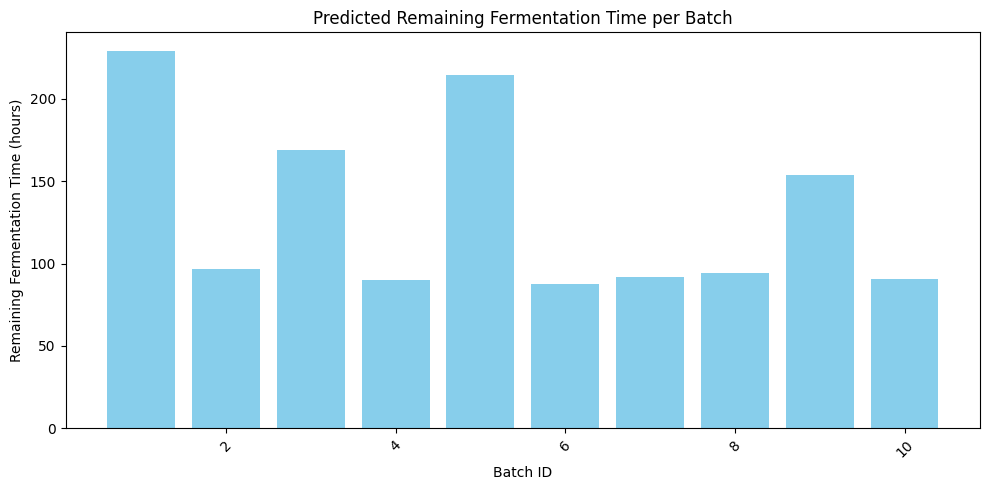

Batch 1: เหลือเวลา ~228.9 ชั่วโมง หรือ ~9.5 วัน
Batch 2: เหลือเวลา ~96.8 ชั่วโมง หรือ ~4.0 วัน
Batch 3: เหลือเวลา ~168.9 ชั่วโมง หรือ ~7.0 วัน
Batch 4: เหลือเวลา ~90.1 ชั่วโมง หรือ ~3.8 วัน
Batch 5: เหลือเวลา ~214.7 ชั่วโมง หรือ ~8.9 วัน
Batch 6: เหลือเวลา ~87.8 ชั่วโมง หรือ ~3.7 วัน
Batch 7: เหลือเวลา ~91.6 ชั่วโมง หรือ ~3.8 วัน
Batch 8: เหลือเวลา ~94.6 ชั่วโมง หรือ ~3.9 วัน
Batch 9: เหลือเวลา ~153.7 ชั่วโมง หรือ ~6.4 วัน
Batch 10: เหลือเวลา ~90.4 ชั่วโมง หรือ ~3.8 วัน


In [ ]:
import matplotlib.pyplot as plt

# ฟังก์ชันทำนาย RFT จากข้อมูลล่าสุดของ batch และ plot graph
def predict_rft_latest(df, model, scaler, window=WINDOW, features=FEATURES):
    """
    df: ข้อมูล unseen ทั้งหมด (มีคอลัมน์ 'Batch')
    model: โมเดล ANN/RNN ที่ฝึกแล้ว
    scaler: StandardScaler ที่ fit จาก training data
    window: ขนาด sequence สำหรับทำนาย
    features: รายชื่อ feature columns
    """
    batches = df['Batch'].unique()
    results = []

    for batch_id in batches:
        df_batch = df[df['Batch'] == batch_id].tail(window)
        if len(df_batch) < window:
            print(f"Batch {batch_id}: ข้อมูลล่าสุดมีเพียง {len(df_batch)} ชั่วโมง ไม่เพียงพอสำหรับ window ขนาด {window}")
            continue

        # เตรียมข้อมูลสำหรับ prediction
        X_input = df_batch[features].values.reshape(1, window, len(features))  # 3D สำหรับ RNN
        X_input_flat = X_input.reshape(1, -1)  # Flatten เพื่อ scale
        X_input_scaled = scaler.transform(X_input_flat).reshape(1, window, len(features))

        # Predict RFT
        rft_pred_hours = model.predict(X_input_scaled)[0][0]
        rft_pred_days = rft_pred_hours / 24
        results.append((batch_id, rft_pred_hours, rft_pred_days))

    # Plot graph
    if results:
        batch_ids, hours_list, days_list = zip(*results)
        plt.figure(figsize=(10,5))
        plt.bar(batch_ids, hours_list, color='skyblue')
        plt.xlabel("Batch ID")
        plt.ylabel("Remaining Fermentation Time (hours)")
        plt.title("Predicted Remaining Fermentation Time per Batch")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return results

# ใช้ฟังก์ชัน
rft_predictions = predict_rft_latest(df_unseen, model, scaler)

# แสดงผล
for batch_id, hours, days in rft_predictions:
    print(f"Batch {batch_id}: เหลือเวลา ~{hours:.1f} ชั่วโมง หรือ ~{days:.1f} วัน")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


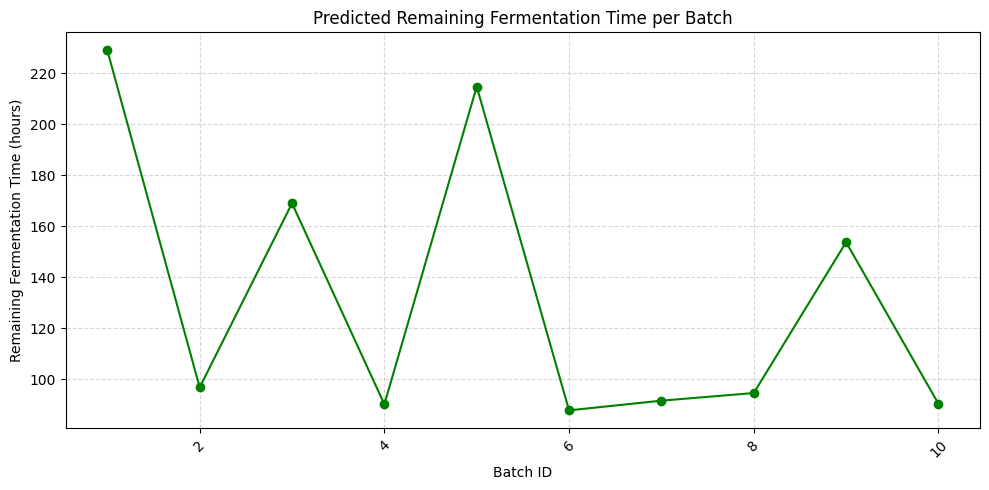

Batch 1: เหลือเวลา ~228.9 ชั่วโมง หรือ ~9.5 วัน
Batch 2: เหลือเวลา ~96.8 ชั่วโมง หรือ ~4.0 วัน
Batch 3: เหลือเวลา ~168.9 ชั่วโมง หรือ ~7.0 วัน
Batch 4: เหลือเวลา ~90.1 ชั่วโมง หรือ ~3.8 วัน
Batch 5: เหลือเวลา ~214.7 ชั่วโมง หรือ ~8.9 วัน
Batch 6: เหลือเวลา ~87.8 ชั่วโมง หรือ ~3.7 วัน
Batch 7: เหลือเวลา ~91.6 ชั่วโมง หรือ ~3.8 วัน
Batch 8: เหลือเวลา ~94.6 ชั่วโมง หรือ ~3.9 วัน
Batch 9: เหลือเวลา ~153.7 ชั่วโมง หรือ ~6.4 วัน
Batch 10: เหลือเวลา ~90.4 ชั่วโมง หรือ ~3.8 วัน


In [ ]:
import matplotlib.pyplot as plt

# ฟังก์ชันทำนาย RFT จากข้อมูลล่าสุดของ batch และ plot line graph
def predict_rft_latest(df, model, scaler, window=WINDOW, features=FEATURES):
    """
    df: ข้อมูล unseen ทั้งหมด (มีคอลัมน์ 'Batch')
    model: โมเดล ANN/RNN ที่ฝึกแล้ว
    scaler: StandardScaler ที่ fit จาก training data
    window: ขนาด sequence สำหรับทำนาย
    features: รายชื่อ feature columns
    """
    batches = df['Batch'].unique()
    results = []

    for batch_id in batches:
        df_batch = df[df['Batch'] == batch_id].tail(window)
        if len(df_batch) < window:
            print(f"Batch {batch_id}: ข้อมูลล่าสุดมีเพียง {len(df_batch)} ชั่วโมง ไม่เพียงพอสำหรับ window ขนาด {window}")
            continue

        # เตรียมข้อมูลสำหรับ prediction
        X_input = df_batch[features].values.reshape(1, window, len(features))  # 3D สำหรับ RNN
        X_input_flat = X_input.reshape(1, -1)  # Flatten เพื่อ scale
        X_input_scaled = scaler.transform(X_input_flat).reshape(1, window, len(features))

        # Predict RFT
        rft_pred_hours = model.predict(X_input_scaled)[0][0]
        rft_pred_days = rft_pred_hours / 24
        results.append((batch_id, rft_pred_hours, rft_pred_days))

    # Plot line graph
    if results:
        batch_ids, hours_list, days_list = zip(*results)
        plt.figure(figsize=(10,5))
        plt.plot(batch_ids, hours_list, marker='o', linestyle='-', color='green')
        plt.xlabel("Batch ID")
        plt.ylabel("Remaining Fermentation Time (hours)")
        plt.title("Predicted Remaining Fermentation Time per Batch")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    return results

# ใช้ฟังก์ชัน
rft_predictions = predict_rft_latest(df_unseen, model, scaler)

# แสดงผล
for batch_id, hours, days in rft_predictions:
    print(f"Batch {batch_id}: เหลือเวลา ~{hours:.1f} ชั่วโมง หรือ ~{days:.1f} วัน")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


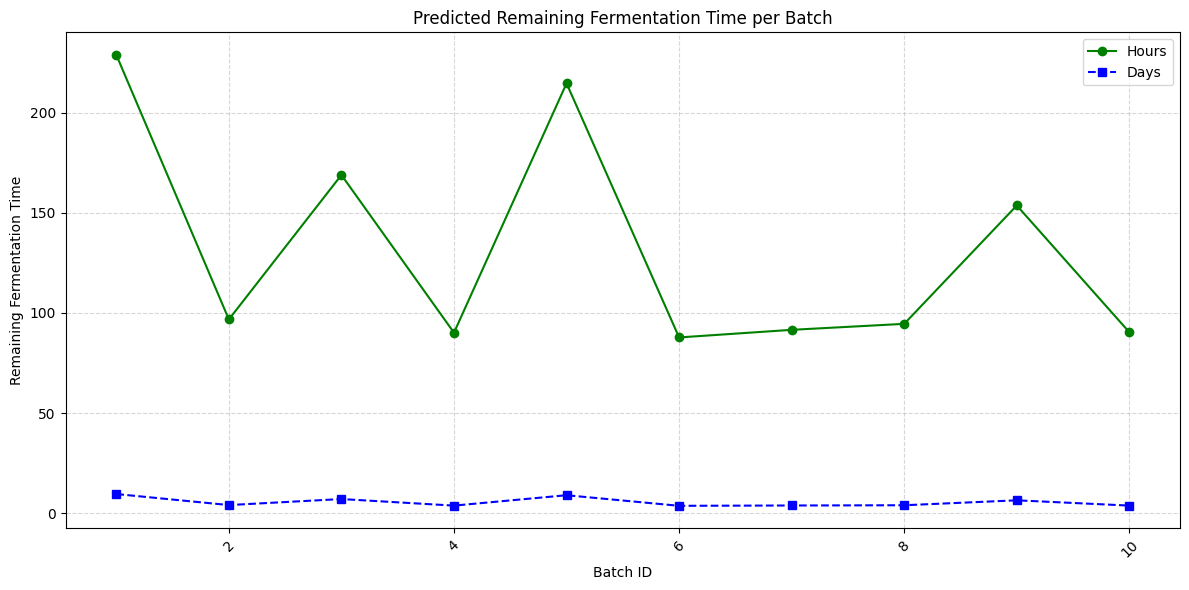

Batch 1: เหลือเวลา ~228.9 ชั่วโมง หรือ ~9.5 วัน
Batch 2: เหลือเวลา ~96.8 ชั่วโมง หรือ ~4.0 วัน
Batch 3: เหลือเวลา ~168.9 ชั่วโมง หรือ ~7.0 วัน
Batch 4: เหลือเวลา ~90.1 ชั่วโมง หรือ ~3.8 วัน
Batch 5: เหลือเวลา ~214.7 ชั่วโมง หรือ ~8.9 วัน
Batch 6: เหลือเวลา ~87.8 ชั่วโมง หรือ ~3.7 วัน
Batch 7: เหลือเวลา ~91.6 ชั่วโมง หรือ ~3.8 วัน
Batch 8: เหลือเวลา ~94.6 ชั่วโมง หรือ ~3.9 วัน
Batch 9: เหลือเวลา ~153.7 ชั่วโมง หรือ ~6.4 วัน
Batch 10: เหลือเวลา ~90.4 ชั่วโมง หรือ ~3.8 วัน


In [ ]:
import matplotlib.pyplot as plt

# ฟังก์ชันทำนาย RFT จากข้อมูลล่าสุดของ batch และ plot line graph (hours + days)
def predict_rft_latest(df, model, scaler, window=WINDOW, features=FEATURES):
    """
    df: ข้อมูล unseen ทั้งหมด (มีคอลัมน์ 'Batch')
    model: โมเดล ANN/RNN ที่ฝึกแล้ว
    scaler: StandardScaler ที่ fit จาก training data
    window: ขนาด sequence สำหรับทำนาย
    features: รายชื่อ feature columns
    """
    batches = df['Batch'].unique()
    results = []

    for batch_id in batches:
        df_batch = df[df['Batch'] == batch_id].tail(window)
        if len(df_batch) < window:
            print(f"Batch {batch_id}: ข้อมูลล่าสุดมีเพียง {len(df_batch)} ชั่วโมง ไม่เพียงพอสำหรับ window ขนาด {window}")
            continue

        # เตรียมข้อมูลสำหรับ prediction
        X_input = df_batch[features].values.reshape(1, window, len(features))  # 3D สำหรับ RNN
        X_input_flat = X_input.reshape(1, -1)  # Flatten เพื่อ scale
        X_input_scaled = scaler.transform(X_input_flat).reshape(1, window, len(features))

        # Predict RFT
        rft_pred_hours = model.predict(X_input_scaled)[0][0]
        rft_pred_days = rft_pred_hours / 24
        results.append((batch_id, rft_pred_hours, rft_pred_days))

    # Plot line graph (hours + days)
    if results:
        batch_ids, hours_list, days_list = zip(*results)
        plt.figure(figsize=(12,6))
        plt.plot(batch_ids, hours_list, marker='o', linestyle='-', color='green', label='Hours')
        plt.plot(batch_ids, days_list, marker='s', linestyle='--', color='blue', label='Days')
        plt.xlabel("Batch ID")
        plt.ylabel("Remaining Fermentation Time")
        plt.title("Predicted Remaining Fermentation Time per Batch")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return results

# ใช้ฟังก์ชัน
rft_predictions = predict_rft_latest(df_unseen, model, scaler)

# แสดงผล
for batch_id, hours, days in rft_predictions:
    print(f"Batch {batch_id}: เหลือเวลา ~{hours:.1f} ชั่วโมง หรือ ~{days:.1f} วัน")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

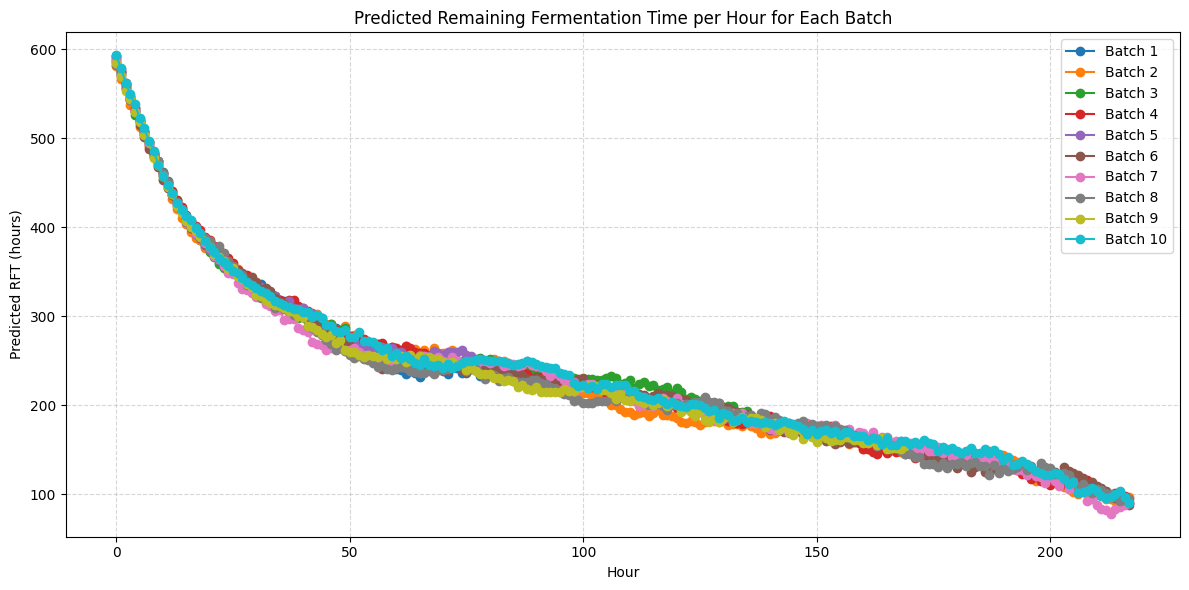

Batch 1: Predicted RFT (hours) = [592.2 575.  560.1 548.1 533.7 519.5 507.3 495.8 483.5 471.4 461.7 452.
 439.4 429.7 421.3 410.5 402.5 395.7 385.3 378.3 374.5 369.2 360.7 357.6
 357.9 348.9 348.2 348.2 339.9 341.7 335.8 335.9 326.8 327.2 322.9 318.6
 317.4 314.1 309.  305.7 304.4 301.5 295.9 297.7 298.6 288.8 289.7 286.6
 281.1 275.9 274.9 265.8 266.8 261.1 261.3 255.9 251.  248.3 252.1 240.5
 240.3 239.2 235.3 238.1 236.1 231.9 241.3 241.8 235.6 242.6 240.6 235.1
 241.6 241.3 235.7 235.6 240.5 239.2 233.  235.  233.9 234.6 232.9 233.6
 232.3 229.6 231.8 230.2 228.9 231.5 228.2 229.9 229.7 227.6 229.4 230.2
 227.  228.9]
Batch 2: Predicted RFT (hours) = [581.4 566.5 556.3 537.7 530.9 513.3 506.9 490.1 479.9 469.  454.7 444.3
 432.  420.9 410.3 403.6 395.  388.1 385.7 377.2 378.5 367.6 367.9 359.2
 358.4 352.  352.7 344.3 344.7 337.7 334.1 328.1 324.2 323.2 315.1 314.6
 314.5 309.1 306.4 304.8 305.4 303.4 297.1 302.4 290.6 290.7 290.8 284.3
 280.7 288.7 277.4 279.3 275.8 270.9 268.9 26

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def predict_rft_hourly(df, model, scaler, window=WINDOW, features=FEATURES):
    """
    Predict remaining fermentation time (RFT) for each batch at each hour.
    df: ข้อมูล unseen ทั้งหมด (ต้องมีคอลัมน์ 'Batch')
    model: trained ANN/RNN
    scaler: StandardScaler fit from training data
    window: sequence length
    features: list of feature columns
    """
    batches = df['Batch'].unique()
    results = []

    plt.figure(figsize=(12,6))

    for batch_id in batches:
        df_batch = df[df['Batch'] == batch_id].reset_index(drop=True)
        if len(df_batch) < window:
            print(f"Batch {batch_id}: ข้อมูลล่าสุดมีเพียง {len(df_batch)} ชั่วโมง ไม่เพียงพอสำหรับ window ขนาด {window}")
            continue

        # Predict RFT for each hour (sliding window)
        rft_hours_list = []
        for i in range(len(df_batch) - window + 1):
            X_input = df_batch[features].iloc[i:i+window].values.reshape(1, window, len(features))
            X_input_flat = X_input.reshape(1, -1)
            X_input_scaled = scaler.transform(X_input_flat).reshape(1, window, len(features))
            rft_pred_hours = model.predict(X_input_scaled)[0][0]
            rft_hours_list.append(rft_pred_hours)

        results.append((batch_id, rft_hours_list))
        plt.plot(range(len(rft_hours_list)), rft_hours_list, marker='o', linestyle='-', label=f'Batch {batch_id}')

    plt.xlabel("Hour")
    plt.ylabel("Predicted RFT (hours)")
    plt.title("Predicted Remaining Fermentation Time per Hour for Each Batch")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return results

# ใช้ฟังก์ชัน
rft_hourly_predictions = predict_rft_hourly(df_unseen, model, scaler)

# แสดงผลตัวอย่าง
for batch_id, rft_list in rft_hourly_predictions:
    print(f"Batch {batch_id}: Predicted RFT (hours) = {np.round(rft_list,1)}")


In [ ]:
# Save the trained model
model.save('fermentation_rft_model.keras')
print("Model saved as 'fermentation_rft_model.keras'")

Model saved as 'fermentation_rft_model.keras'


In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd

# โหลดโมเดลที่บันทึกไว้
loaded_model = load_model('fermentation_rft_model.keras')

# แสดง summary ของโมเดลที่โหลดมา (เพื่อตรวจสอบว่าโหลดถูกต้อง)
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,965 (97.52 KB)

 Trainable params: 8,321 (32.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 16,644 (65.02 KB)

In [ ]:
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]
print("Uploaded file:", filename)

Saving unseen_wild_grape-1H_0_5D_T29.csv to unseen_wild_grape-1H_0_5D_T29.csv
Uploaded file: unseen_wild_grape-1H_0_5D_T29.csv


In [ ]:
import pandas as pd

df_unseen = pd.read_csv(filename)
df_unseen.head()

,Fruit,Batch,Time (Hour),Temperature (°C),pH,Sugar (°Brix),Alcohol (% v/v)
0,Wild Grape,1,0,28.94,3.59,18.02,0.03
1,Wild Grape,1,1,28.76,3.60,17.90,0.37
2,Wild Grape,1,2,28.65,3.58,17.95,0.60
3,Wild Grape,1,3,29.00,3.58,17.81,0.93
4,Wild Grape,1,4,29.00,3.57,17.75,1.14


In [ ]:
# ตัวอย่างการนำโมเดลที่โหลดมาใช้งาน
# สมมติว่ามีข้อมูลล่าสุด 24 ชั่วโมง (เท่ากับขนาด WINDOW) สำหรับการทำนาย
# ในตัวอย่างนี้ จะใช้ข้อมูล 24 ชั่วโมงล่าสุดจาก df_unseen ที่เรามีอยู่

# ตรวจสอบให้แน่ใจว่ามีข้อมูลอย่างน้อยเท่ากับ WINDOW
if len(df_unseen) < WINDOW:
    print(f"ข้อมูลใน df_unseen มีเพียง {len(df_unseen)} ชั่วโมง ไม่เพียงพอสำหรับการทำนายด้วย window ขนาด {WINDOW} ชั่วโมง")
else:
    # เลือกข้อมูล 24 ชั่วโมงล่าสุด
    recent_data = df_unseen.tail(WINDOW)[FEATURES].values

    # ทำการ Scaling ข้อมูลล่าสุดด้วย scaler เดิมที่เรา fit ไว้กับ training data
    # ต้อง reshape ให้เป็น 2D ก่อน scale
    recent_data_flat = recent_data.reshape(1, -1)
    recent_data_scaled = scaler.transform(recent_data_flat)

    # Reshape ข้อมูลที่ scaled แล้วกลับเป็น 3D (samples, timesteps, features)
    # samples = 1 เพราะเราทำนายทีละ 1 sequence (ข้อมูลล่าสุด 24 ชั่วโมง)
    recent_data_scaled_3d = recent_data_scaled.reshape(1, WINDOW, len(FEATURES))

    # ใช้โมเดลที่โหลดมาทำนาย
    predicted_rft = loaded_model.predict(recent_data_scaled_3d)

    # แสดงผลการทำนาย
    rft_pred_hours = predicted_rft[0][0]
    rft_pred_days = rft_pred_hours / 24
    print(f"\nPredicted Remaining Fermentation Time (using loaded model):")
    print(f"~{rft_pred_hours:.1f} hours or ~{rft_pred_days:.1f} day")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

Predicted Remaining Fermentation Time (using loaded model):
~192.9 hours or ~8.0 day


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━

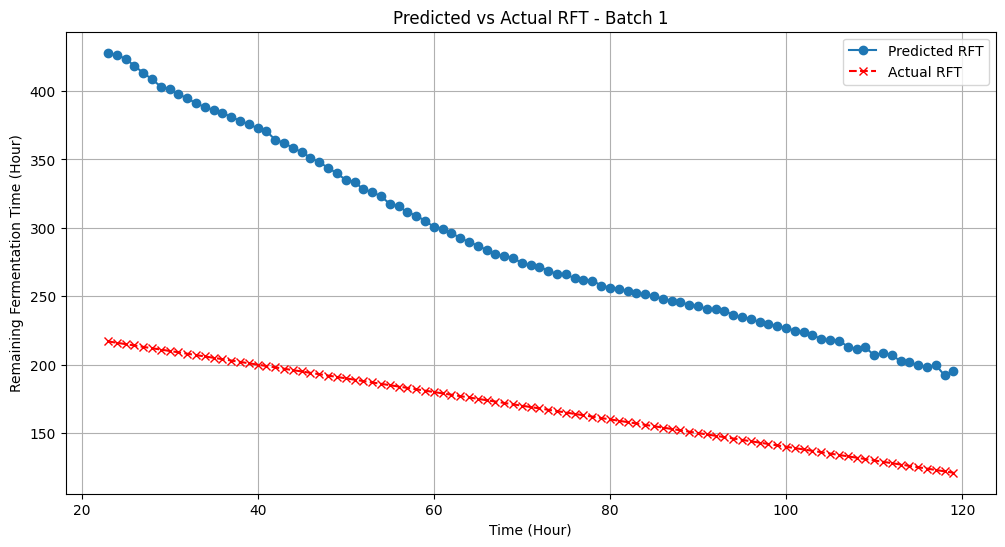

In [ ]:
import matplotlib.pyplot as plt

def plot_unseen_predictions(df, model, scaler, window=WINDOW, features=FEATURES):
    """
    df: ข้อมูล unseen ทั้งหมด (มีคอลัมน์ 'Batch')
    model: โมเดล ANN/RNN ที่ฝึกแล้ว
    scaler: StandardScaler ที่ fit จาก training data
    window: ขนาด sequence สำหรับทำนาย
    features: รายชื่อ feature columns
    """
    batches = df['Batch'].unique()

    # Add RFT column to the unseen data
    # Assuming total fermentation time is 240 hours, similar to the training data
    TOTAL_FERMENTATION_TIME = 240
    df['RFT'] = TOTAL_FERMENTATION_TIME - df['Time (Hour)']


    for batch_id in batches:
        df_batch = df[df['Batch'] == batch_id].sort_values('Time (Hour)').reset_index(drop=True)
        times, rft_preds = [], []
        actual_rft = []

        # ทำนาย RFT สำหรับแต่ละจุดข้อมูลที่สามารถสร้าง sequence ได้
        for i in range(window, len(df_batch)):
            recent = df_batch.iloc[i-window:i]
            X_input = recent[features].values.reshape(1, window, len(features))
            X_input_flat = X_input.reshape(1, -1)
            X_input_scaled = scaler.transform(X_input_flat).reshape(1, window, len(features))

            rft_pred = model.predict(X_input_scaled)[0][0]

            times.append(df_batch['Time (Hour)'].iloc[i-1]) # เวลาของจุดสุดท้ายใน sequence
            rft_preds.append(rft_pred)
            actual_rft.append(df_batch['RFT'].iloc[i-1]) # RFT จริงของจุดสุดท้ายใน sequence


        if times: # ตรวจสอบว่ามีข้อมูลสำหรับการ plot หรือไม่
            plt.figure(figsize=(12,6))
            plt.plot(times, rft_preds, marker='o', label='Predicted RFT')
            plt.plot(times, actual_rft, marker='x', linestyle='--', color='red', label='Actual RFT') # Plot RFT จริง
            plt.xlabel("Time (Hour)")
            plt.ylabel("Remaining Fermentation Time (Hour)")
            plt.title(f"Predicted vs Actual RFT - Batch {batch_id}")
            plt.legend()
            plt.grid(True)
            plt.show()
        else:
            print(f"Batch {batch_id}: ไม่พบข้อมูลเพียงพอ ({len(df_batch)} ชั่วโมง) สำหรับการสร้าง sequence ขนาด {window}")


# ใช้ฟังก์ชัน plot สำหรับ df_unseen
plot_unseen_predictions(df_unseen, loaded_model, scaler)

In [ ]:
print(f"Mean Absolute Error (MAE) on Test Set: {mae:.2f} hours")
print(f"Mean Absolute Error (MAE) on Unseen Data: {mae_unseen:.2f} hours")

Mean Absolute Error (MAE) on Test Set: 1.31 hours
Mean Absolute Error (MAE) on Unseen Data: 131.40 hours
